# MAGIC GAMMA TELESCOPE : PREDICTING SIGNAL OR BACKGROUND

The data are MC generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). Read more at : https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

The data set was generated by a Monte Carlo program, Corsika, described in: 
D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, 
Forschungszentrum Karlsruhe FZKA 6019 (1998). 
Attribute Information:

1. fLength: (continuous)- major axis of ellipse [mm] 
2. fWidth:  (continuous)- minor axis of ellipse [mm] 
3. fSize:   (continuous)- 10-log of sum of content of all pixels [in #phot] 
4. fConc:   (continuous)- ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1:  (continuous)- ratio of highest pixel over fSize [ratio] 
6. fAsym:   (continuous)- distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: (continuous)- 3rd root of third moment along major axis [mm] 
8. fM3Trans:(continuous)- 3rd root of third moment along minor axis [mm] 
9. fAlpha:  (continuous)- angle of major axis with vector to origin [deg] 
10. fDist:  (continuous)- distance from origin to center of ellipse [mm] 
11. class: g,h  gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

The task here is to predict whether the collected Cherenkov photons are primary gammas/signals or hadronic showers/background making good use of the observed features.

The data analysis is done in R

Import required libraries

In [1]:
library(caTools)
library(ggplot2)
library(lattice)
library(caret)
library(class)
library(e1071)
library(rpart)
library(randomForest)
library(GGally)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



## Read the dataset

In [2]:
# Importing the dataset
magicgamma <- read.csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"))

In [3]:
head(magicgamma,10)
dim(magicgamma)

X28.7967,X16.0021,X2.6449,X0.3918,X0.1982,X27.7004,X22.011,X.8.2027,X40.092,X81.8828,g
31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,g
162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.788,g
23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.737,g
75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.462,g
51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.098,g
48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.087,g
26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.134,g
96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.226,g
46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.251,g
62.7766,29.9104,3.3331,0.2475,0.1261,-33.9065,57.5848,23.7710,9.9144,323.094,g


[1] 19019    11

## Data Preprocessing

In [4]:
#checking for NA's
sum(is.na(magicgamma))

[1] 0

The dataset has 19019 rows and 11 feature columns. Also there are no NA's present. Now lets randomly shuffle the dataset

In [5]:
magicgamma <- magicgamma[sample(1:nrow(magicgamma)),]
head(magicgamma,10)

,X28.7967,X16.0021,X2.6449,X0.3918,X0.1982,X27.7004,X22.011,X.8.2027,X40.092,X81.8828,g
10783,12.9691,10.9907,2.2589,0.7438,0.4601,13.9944,-6.6805,7.9720,32.8160,132.1480,g
1215,24.3237,16.9759,2.6684,0.3970,0.2436,3.0799,21.8963,8.8449,53.3158,120.4050,g
2985,28.5443,9.8997,2.3901,0.5132,0.2668,5.0713,23.6104,7.3634,11.3856,185.7730,g
12987,46.2067,6.3890,2.6149,0.5194,0.2973,24.9479,37.3093,5.4582,47.6534,195.9500,h
6693,19.9428,16.0295,2.2188,0.4350,0.2266,-6.4350,18.1783,-2.0147,44.0604,74.6269,g
13856,29.8141,12.5051,2.5442,0.6812,0.4576,23.0724,16.2367,-7.8348,11.9557,153.8474,h
4000,94.9230,25.5776,3.4601,0.1491,0.0754,-60.3048,89.4115,15.5445,0.4546,278.7370,g
7917,45.9104,20.7149,2.8485,0.2481,0.1254,-7.2447,-22.0213,-14.1643,7.2060,189.4150,g
8063,35.1579,16.1087,2.6279,0.3039,0.1708,38.9387,23.9530,14.9750,2.6246,188.2310,g
8237,78.4848,13.4146,2.4983,0.4444,0.2778,94.0254,-41.0307,8.0336,0.1300,202.0400,g


Assign column names from the given descriptions of the data.

In [6]:
colnames(magicgamma) <- c("fLength","fWidth","fSize","fConc","fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class")

In [7]:
head(magicgamma,10)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
10783,12.9691,10.9907,2.2589,0.7438,0.4601,13.9944,-6.6805,7.9720,32.8160,132.1480,g
1215,24.3237,16.9759,2.6684,0.3970,0.2436,3.0799,21.8963,8.8449,53.3158,120.4050,g
2985,28.5443,9.8997,2.3901,0.5132,0.2668,5.0713,23.6104,7.3634,11.3856,185.7730,g
12987,46.2067,6.3890,2.6149,0.5194,0.2973,24.9479,37.3093,5.4582,47.6534,195.9500,h
6693,19.9428,16.0295,2.2188,0.4350,0.2266,-6.4350,18.1783,-2.0147,44.0604,74.6269,g
13856,29.8141,12.5051,2.5442,0.6812,0.4576,23.0724,16.2367,-7.8348,11.9557,153.8474,h
4000,94.9230,25.5776,3.4601,0.1491,0.0754,-60.3048,89.4115,15.5445,0.4546,278.7370,g
7917,45.9104,20.7149,2.8485,0.2481,0.1254,-7.2447,-22.0213,-14.1643,7.2060,189.4150,g
8063,35.1579,16.1087,2.6279,0.3039,0.1708,38.9387,23.9530,14.9750,2.6246,188.2310,g
8237,78.4848,13.4146,2.4983,0.4444,0.2778,94.0254,-41.0307,8.0336,0.1300,202.0400,g


The target variable is class having values 'g' for signal and 'h' for background. 

Now encode the target as factors, with 1 for g and 0 for h.

In [8]:
# Encoding the target feature as factor
magicgamma$class = ifelse(magicgamma$class == 'g',1,0)
magicgamma$class = factor(magicgamma$class)
head(magicgamma,10)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
10783,12.9691,10.9907,2.2589,0.7438,0.4601,13.9944,-6.6805,7.9720,32.8160,132.1480,1
1215,24.3237,16.9759,2.6684,0.3970,0.2436,3.0799,21.8963,8.8449,53.3158,120.4050,1
2985,28.5443,9.8997,2.3901,0.5132,0.2668,5.0713,23.6104,7.3634,11.3856,185.7730,1
12987,46.2067,6.3890,2.6149,0.5194,0.2973,24.9479,37.3093,5.4582,47.6534,195.9500,0
6693,19.9428,16.0295,2.2188,0.4350,0.2266,-6.4350,18.1783,-2.0147,44.0604,74.6269,1
13856,29.8141,12.5051,2.5442,0.6812,0.4576,23.0724,16.2367,-7.8348,11.9557,153.8474,0
4000,94.9230,25.5776,3.4601,0.1491,0.0754,-60.3048,89.4115,15.5445,0.4546,278.7370,1
7917,45.9104,20.7149,2.8485,0.2481,0.1254,-7.2447,-22.0213,-14.1643,7.2060,189.4150,1
8063,35.1579,16.1087,2.6279,0.3039,0.1708,38.9387,23.9530,14.9750,2.6246,188.2310,1
8237,78.4848,13.4146,2.4983,0.4444,0.2778,94.0254,-41.0307,8.0336,0.1300,202.0400,1


Lets plot a pairplot between the feature variables.

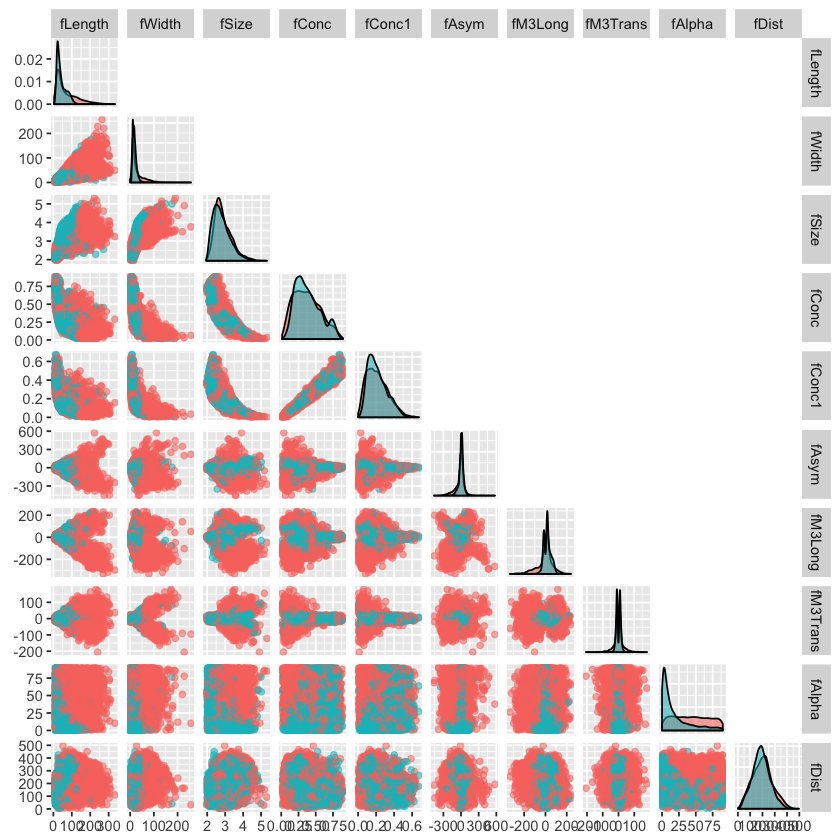

In [9]:
ggpairs(magicgamma, columns = 1:10, upper = "blank", aes(colour = class, alpha = 0.8))

As we observe from the above pariplots, the data is highly nonlinear. i e. one can observe patterns of nonlinearity between the feature variables. The data is supposed to be dealt with by a complex classifier !

Split the dataset into training set(75%) and test set(25%) for further analysis.

In [10]:
# Splitting the dataset into the Training set and Test set
set.seed(123)
split = sample.split(magicgamma$class, SplitRatio = 0.75)
training_set = subset(magicgamma, split == TRUE)
test_set = subset(magicgamma, split == FALSE)

## Fitting Classifier to the Data

Lets start off with the simple Logistic Regression and see how accurate it is to make predictions on the test set.

In [11]:
# Fitting Logistic Regression to the Training set
classifier = glm(formula = class ~ .,
                 family = binomial,
                 data = training_set)

Now print the summary statistics to find which feature variables are relevant.

In [12]:
summary(classifier)


Call:
glm(formula = class ~ ., family = binomial, data = training_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4762  -0.6694   0.4665   0.6685   3.8891  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.5077218  0.3583139  18.162  < 2e-16 ***
fLength     -0.0285018  0.0012029 -23.694  < 2e-16 ***
fWidth      -0.0056699  0.0027990  -2.026   0.0428 *  
fSize       -0.6443317  0.1108416  -5.813 6.13e-09 ***
fConc       -0.0392986  0.5953791  -0.066   0.9474    
fConc1      -5.1671372  0.8610897  -6.001 1.96e-09 ***
fAsym        0.0001117  0.0004940   0.226   0.8210    
fM3Long      0.0066152  0.0006028  10.973  < 2e-16 ***
fM3Trans     0.0004707  0.0013120   0.359   0.7198    
fAlpha      -0.0445588  0.0009785 -45.539  < 2e-16 ***
fDist       -0.0005515  0.0003444  -1.602   0.1093    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null devi

Now make predictions on the dataset. The classifier outputs probabilities which are converted into actual (1 or 0) predictions against a threshold of 0.5

In [13]:
# Predicting the Test set results
prob_pred <- predict(classifier, type = 'response', newdata = test_set[-11])
y_pred <- ifelse(prob_pred > 0.5, 1, 0)

Now lets create and print a confusion matrix making use of the caret package

In [14]:
# Making the Confusion Matrix
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1005  296
         1  667 2787
                                          
               Accuracy : 0.7975          
                 95% CI : (0.7858, 0.8088)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5321          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6011          
            Specificity : 0.9040          
         Pos Pred Value : 0.7725          
         Neg Pred Value : 0.8069          
             Prevalence : 0.3516          
         Detection Rate : 0.2114          
   Detection Prevalence : 0.2736          
      Balanced Accuracy : 0.7525          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

As we can see, the Logistic Regression classifier has made a total of 1005+2787 = 3792 correct predictions, giving out an accuracy of 0.79. 

I strongly believe, there is good scope of building a better model with other nonlinear classifiers. So lets move on.

Observe that some features such as fConc, fAsym, fM3Trans, fDist do have higher z-probability values indicating that they are statistically insignificant. Lets try to re-build the classifier, eliminating these variables.

In [15]:
# Fitting Logistic Regression to the Training set
classifier = glm(formula = class ~.-fConc-fAsym-fM3Trans-fDist,
                 family = binomial,
                 data = training_set)

In [16]:
summary(classifier)
# Predicting the Test set results
prob_pred = predict(classifier, type = 'response', newdata = test_set[-11])
y_pred = ifelse(prob_pred > 0.5, 1, 0)
# Making the Confusion Matrix
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix


Call:
glm(formula = class ~ . - fConc - fAsym - fM3Trans - fDist, family = binomial, 
    data = training_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4777  -0.6674   0.4679   0.6680   3.9379  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.5051644  0.3145543  20.681  < 2e-16 ***
fLength     -0.0290916  0.0011260 -25.835  < 2e-16 ***
fWidth      -0.0056798  0.0027962  -2.031   0.0422 *  
fSize       -0.6686298  0.1013053  -6.600 4.11e-11 ***
fConc1      -5.3190024  0.3308546 -16.077  < 2e-16 ***
fM3Long      0.0067096  0.0005893  11.385  < 2e-16 ***
fAlpha      -0.0442387  0.0009528 -46.430  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 18499  on 14263  degrees of freedom
Residual deviance: 13183  on 14257  degrees of freedom
AIC: 13197

Number of Fisher Scoring iterations: 5


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1006  295
         1  666 2788
                                          
               Accuracy : 0.7979          
                 95% CI : (0.7862, 0.8092)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5331          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6017          
            Specificity : 0.9043          
         Pos Pred Value : 0.7733          
         Neg Pred Value : 0.8072          
             Prevalence : 0.3516          
         Detection Rate : 0.2116          
   Detection Prevalence : 0.2736          
      Balanced Accuracy : 0.7530          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

Now the classifier has an accuracy of 0.797 with 1006+2788 =3794 correct predictions. Lets not stop here. Lets now build a K-Nearest Neighbours (KNN) algorithm for the same data. Choose the value of k =5 here.

In [17]:
#Building KNN classifier
y_pred = knn(train = training_set[,-11],
             test = test_set[, -11],
             cl = training_set[,11],
             k = 5,
             prob = TRUE)

In [18]:
# Predicting the Test set results
# Making the Confusion Matrix
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1013  258
         1  659 2825
                                          
               Accuracy : 0.8072          
                 95% CI : (0.7956, 0.8183)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5525          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6059          
            Specificity : 0.9163          
         Pos Pred Value : 0.7970          
         Neg Pred Value : 0.8108          
             Prevalence : 0.3516          
         Detection Rate : 0.2130          
   Detection Prevalence : 0.2673          
      Balanced Accuracy : 0.7611          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

This time with the KNN classifier, we have an improved prediction accuracy of 0.80. 

Now lets try Support Vector Machines with Linear and Radial Kernels.

In [19]:
# Fitting SVM with a Linear kernel
classifier = svm(formula = class ~ .,
                 data = training_set,
                 type = 'C-classification',
                 kernel = 'linear')

# Predicting the Test set results
y_pred = predict(classifier, newdata = test_set[-11])
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1018  302
         1  654 2781
                                          
               Accuracy : 0.7989          
                 95% CI : (0.7873, 0.8103)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5368          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6089          
            Specificity : 0.9020          
         Pos Pred Value : 0.7712          
         Neg Pred Value : 0.8096          
             Prevalence : 0.3516          
         Detection Rate : 0.2141          
   Detection Prevalence : 0.2776          
      Balanced Accuracy : 0.7554          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

For SVM classifier with a Linear Kernel, prediction accuarcy is not that great. Why not try the radial kernel ?

In [20]:
# SVM with a radial kernel
classifier = svm(formula = class ~ .,
                 data = training_set,
                 type = 'C-classification',
                 kernel = 'radial')

# Predicting the Test set results
y_pred = predict(classifier, newdata = test_set[-11])
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1181  146
         1  491 2937
                                         
               Accuracy : 0.866          
                 95% CI : (0.856, 0.8756)
    No Information Rate : 0.6484         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6916         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.7063         
            Specificity : 0.9526         
         Pos Pred Value : 0.8900         
         Neg Pred Value : 0.8568         
             Prevalence : 0.3516         
         Detection Rate : 0.2484         
   Detection Prevalence : 0.2791         
      Balanced Accuracy : 0.8295         
                                         
       'Positive' Class : 0              
                                         

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

We observe the accuracy has come upto 0.867 which is quite good. This gives a hint to us that nonlinear classifiers can give an accurate models as far as the data is concerned.

We now build a NaiveBayes, Decision Tree and Random Forest classifiers and see which of them can give the best predictions for the test set chosen.

In [21]:
#NaiveBayes Classifier for the data
classifier = naiveBayes(x = training_set[-11],
                        y = training_set$class)
# Predicting the Test set results
y_pred = predict(classifier, newdata = test_set[-11])

In [22]:
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  638  259
         1 1034 2824
                                          
               Accuracy : 0.7281          
                 95% CI : (0.7152, 0.7407)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3329          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3816          
            Specificity : 0.9160          
         Pos Pred Value : 0.7113          
         Neg Pred Value : 0.7320          
             Prevalence : 0.3516          
         Detection Rate : 0.1342          
   Detection Prevalence : 0.1886          
      Balanced Accuracy : 0.6488          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

In [23]:
# Fitting a Decision Tree classifier
classifier = rpart(formula = class ~ .,
                   data = training_set)

In [24]:
# Predicting the Test set results
y_pred = predict(classifier, newdata = test_set[-11], type = 'class')
# Making the Confusion Matrix
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1015  160
         1  657 2923
                                          
               Accuracy : 0.8282          
                 95% CI : (0.8172, 0.8388)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5957          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6071          
            Specificity : 0.9481          
         Pos Pred Value : 0.8638          
         Neg Pred Value : 0.8165          
             Prevalence : 0.3516          
         Detection Rate : 0.2135          
   Detection Prevalence : 0.2471          
      Balanced Accuracy : 0.7776          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

In [25]:
# Fitting Random Forests classifier
set.seed(123)
classifier <- randomForest(x = training_set[-11],
                          y = training_set$class,
                          ntree = 500)

# Predicting the Test set results
y_pred <- predict(classifier, newdata = test_set[-11])
confusionMatrix(data=y_pred, reference=test_set[,11])
confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1299  184
         1  373 2899
                                          
               Accuracy : 0.8829          
                 95% CI : (0.8734, 0.8919)
    No Information Rate : 0.6484          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7363          
 Mcnemar's Test P-Value : 1.641e-15       
                                          
            Sensitivity : 0.7769          
            Specificity : 0.9403          
         Pos Pred Value : 0.8759          
         Neg Pred Value : 0.8860          
             Prevalence : 0.3516          
         Detection Rate : 0.2732          
   Detection Prevalence : 0.3119          
      Balanced Accuracy : 0.8586          
                                          
       'Positive' Class : 0               
                                          

function (data, ...) 
{
    UseMethod("confusionMatrix")
}
<environment: namespace:caret>

Among all the classifiers, random forests can give out the best accurate predictions, with an accuracy of 0.88

## Conluding Remarks

1. Logistic regression and aa few other classifier models such as Linear SVM, KNN, NaiveBayes are not capable of making good predictions for the magic gamma dataset. This is probably due to the inherent nonlinearitites present in the data.
2. Random Forests classifier  along with SVM with Radial kernel gives the maximum accuracy opredictions. We can coclude that among the various classifiers, kernel SVM and random Forests can capture the nonlinear features of the data to make good predictions. 